## Mount Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Get scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [2]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Nothing to do.
Nothing to do.


In [3]:
from getData import getDataframe
import pandas as pd

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


## Install tf 2.0 and python speech features

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [5]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [0]:
!pip install -q python_speech_features

## Data Generators



In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 60000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=True
)

## Model

![Residual Module](https://www.researchgate.net/profile/Adrien_Deliege/publication/325909052/figure/fig2/AS:640090082668544@1529620776257/Typical-ResNet-module-The-function-Hx-is-approximated-using-the-input-x-and-a-residual.png)

In [26]:
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, add,
    Input, Reshape, BatchNormalization,
    GlobalAveragePooling2D, Dropout, Dense,
    Activation
)
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

def residualModule(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)


    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])

    # Batch normalization
    layer_out = BatchNormalization()(layer_out)

    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out

def resNet(input_shape=(99,40)):
    
    input_layer = Input(shape=(99, 40))
    
    reshape_layer = Reshape(input_shape=input_shape, target_shape=(99, 40, 1))(input_layer)
      
    x = Conv2D(64, (6,4), padding='same', strides=(2, 2), activation='relu')(reshape_layer)
    x = MaxPooling2D((3,2), padding='same', strides=(1, 1))(x)
    x = BatchNormalization()(x)
    
    x = residualModule(x, 64)
    x = residualModule(x, 128)
    x = MaxPooling2D((3,2))(x)
    
    x = residualModule(x, 128)
    x = residualModule(x, 256)
    
    x = GlobalAveragePooling2D()(x)   
    x = Dropout(0.4)(x)
    
    x = Dense(64, activation='relu')(x)
    
    x = Dense(30, activation='softmax')(x)
    
    model = Model(input_layer, x, name='Resnet')
    return model

model = resNet()
model.summary()

Model: "Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 40)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 99, 40, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 20, 64)   1600        reshape[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 20, 64)   0           conv2d[0][0]                     
_____________________________________________________________________________________________

In [0]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["sparse_categorical_accuracy"])

In [28]:
EPOCHS = 50

# Stop if the validation accuracy doesn't imporove for 7 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    patience=7,
    verbose=1
)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1
)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    "resnet.h5",
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True
)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/50
1596/1596 [==============================] - 130s 82ms/step - loss: 0.9464 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.8679
Epoch 2/50
1596/1596 [==============================] - 127s 80ms/step - loss: 0.3037 - sparse_categorical_accuracy: 0.9113 - val_loss: 0.4423 - val_sparse_categorical_accuracy: 0.8687
Epoch 3/50
1596/1596 [==============================] - 126s 79ms/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9334 - val_loss: 0.2286 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/50
1596/1596 [==============================] - 126s 79ms/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9439 - val_loss: 0.3081 - val_sparse_categorical_accuracy: 0.9082
Epoch 5/50
1596/1596 [==============================] - 126s 79ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.9138
Epoch 6/50
1595/1596 [============================>.] - ETA: 0s - loss: 0.1

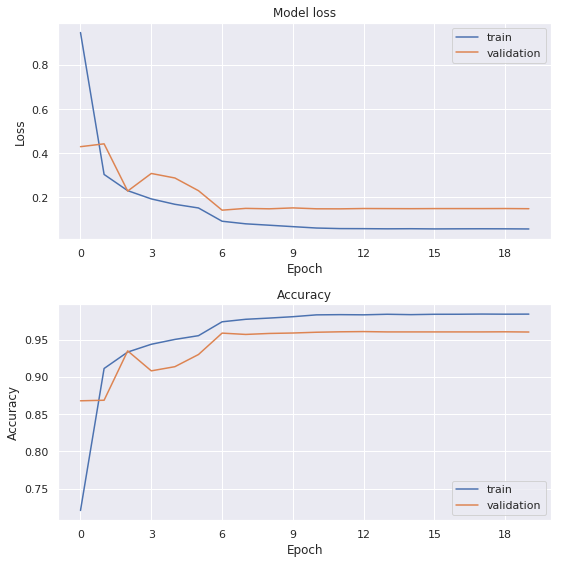

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc, label='train')
ax2.plot(val_acc, label='validation')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
fig.show()

## Predict

In [0]:
test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False,
    scale=True
) 

In [75]:
out = model.predict(test_data, verbose=1)

214/214 [==============================] - 45s 210ms/step


In [0]:
import numpy as np
y_pred = np.argmax(out,axis=1)
y_true = testDF['labels'].tolist() 

In [77]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score,
    f1_score
)

print('Accuracy: {:.4f}'.format(accuracy_score(y_pred, y_true)))
print('Precision: {:.4f}'.format(precision_score(y_pred, y_true, average='macro')))
print('Recall: {:.4f}'.format(recall_score(y_pred, y_true, average='macro')))
print('F1 score: {:.4f}'.format(f1_score(y_pred, y_true, average='macro')))
cm = confusion_matrix(y_pred, y_true)

Accuracy: 0.9595
Precision: 0.9604
Recall: 0.9625
F1 score: 0.9612


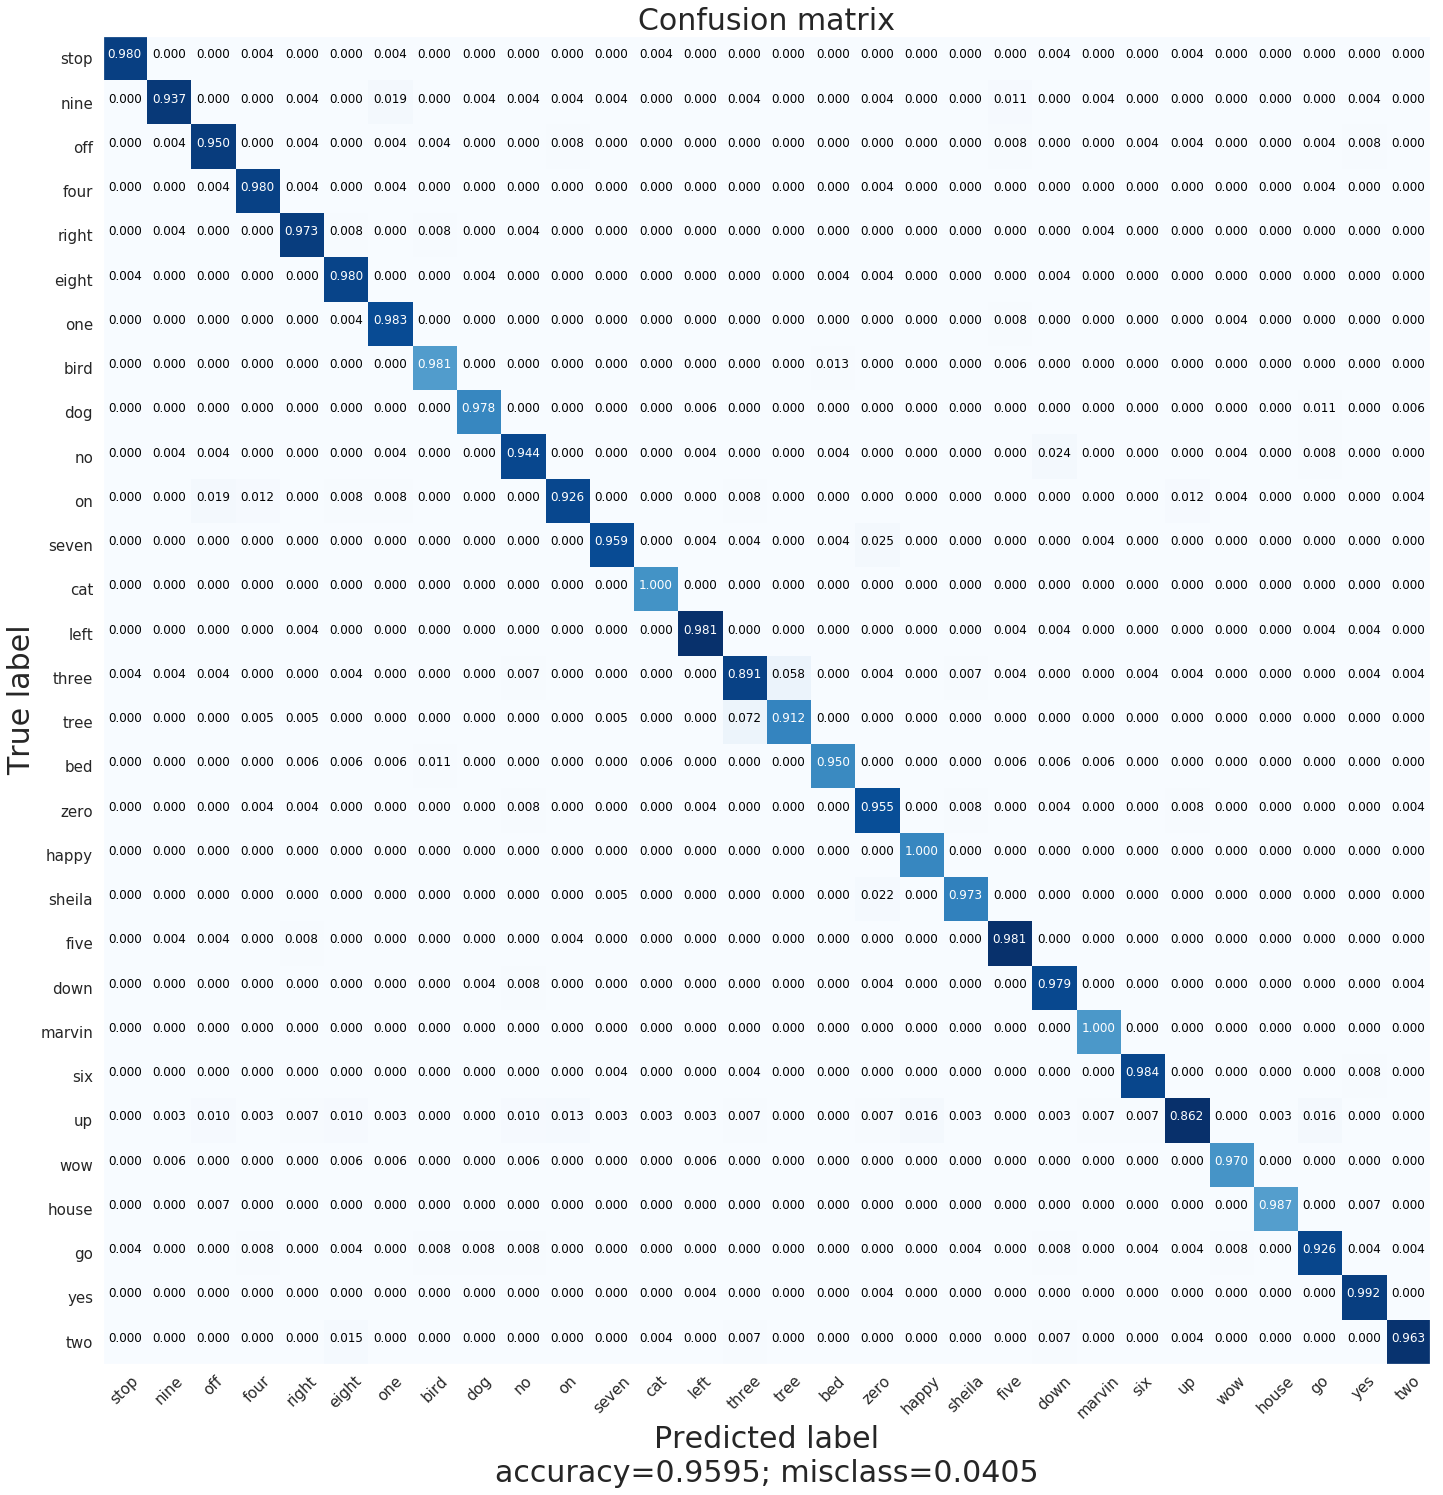

In [78]:
from analysisFunctions import plot_confusion_matrix
from constants import inv_categories
    
plot_confusion_matrix(cm, target_names=list(inv_categories.values())[:-1], normalize=True)

## Save to Drive


In [30]:
import pickle

GDRIVE_PATH = "/content/gdrive/My Drive/speechRecognition/resnet/"

# Save model
model.save(GDRIVE_PATH + "resnet_96.h5")
print("Saved model to drive")

# Save history data
with open(GDRIVE_PATH + "train_history_resnet_96.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved model to drive
Saved training history to drive


## Extract features

In [0]:
# Load model from drive if needed

model = tf.keras.models.load_model("/content/gdrive/My Drive/speechRecognition/resnet/resnet_96.h5")

In [0]:
marvin_data, _ = getDataset(
    df=trainDF.loc[trainDF['category']=='marvin', :],
    batch_size=32,
    cache_file='oc_train_cache',
    shuffle=False,
    scale=True
)

In [33]:
valDF['oc_class'] = valDF.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
val_true = valDF['oc_class'].tolist()
valDF.head()

,files,labels,category,oc_class
0,speechData/train/bed/026290a7_nohash_0.wav,16,bed,-1
1,speechData/train/bed/060cd039_nohash_0.wav,16,bed,-1
2,speechData/train/bed/060cd039_nohash_1.wav,16,bed,-1
3,speechData/train/bed/099d52ad_nohash_0.wav,16,bed,-1
4,speechData/train/bed/0e17f595_nohash_0.wav,16,bed,-1


In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank, _normalize

def _parse_fn(filename):
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave)
    return _normalize(fbank)

In [0]:
def getFeatures(data):
    layer_name = 'dense'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)

In [0]:
import numpy as np
valData = np.zeros((valDF.shape[0], 99, 40))

for i,f in enumerate(valDF['files']):
    valData[i] = _parse_fn(f)

In [0]:
X_train = getFeatures(marvin_data)
X_val = getFeatures(valData)

## PCA

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

pca.fit(X_train)

print(sum(pca.explained_variance_ratio_)) 

0.9917076766723767


In [0]:
X_train_transformed = pca.transform(X_train)
X_val_transformed = pca.transform(X_val)

## Bayesian optimization for OC-SVM 

In [0]:
!pip install -q scikit-optimize

     |████████████████████████████████| 81kB 3.2MB/s 


In [0]:
from skopt.space import Real
from skopt.utils import use_named_args

from sklearn.metrics import f1_score
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

oc_svm = svm.OneClassSVM()

space  = [
    Real(10**-5, 10**0, "log-uniform", name='gamma'),
    Real(10**-5, 10**0, "log-uniform", name='nu')
]

@use_named_args(space)
def objective(**params):
    oc_svm.set_params(**params)
    
    oc_svm.fit(X_train_transformed)
    val_pred = oc_svm.predict(X_val_transformed)
    
    score = f1_score(val_pred, val_true)
   

    return -1*score

In [57]:
from skopt import gp_minimize

res_gp = gp_minimize(objective, space, n_calls=50, n_jobs=-1, verbose=False)
print("Best score={:.4f}".format(-res_gp.fun))

Best score=0.9776


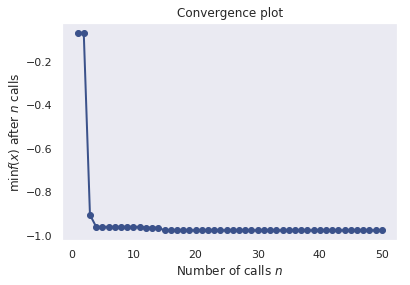

In [58]:
from skopt.plots import plot_convergence

ax = plot_convergence(res_gp)
plt.show()

In [59]:
best_parameters = {k.name: x for k, x in zip(space, res_gp.x)}
best_parameters

{'gamma': 0.0062821146192810935, 'nu': 1.730364202513862e-05}

Accuracy: 0.9990
Precision: 1.0000
Recal: 0.9563
F1-score: 0.9776


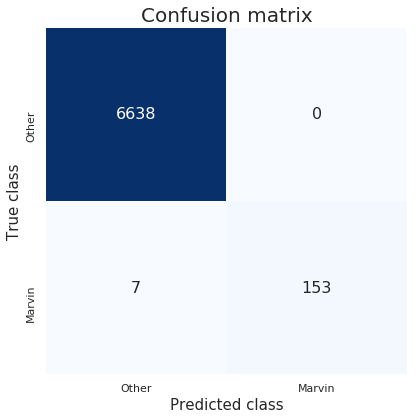

In [69]:
from analysisFunctions import showResultsOC

bestOC = svm.OneClassSVM().set_params(**best_parameters)

bestOC.fit(X_train_transformed)

val_pred = bestOC.predict(X_val_transformed)
showResultsOC(val_pred, val_true)

## Final test

In [0]:
import pandas as pd 

dfTest = pd.concat([testDF,finalTestDF],ignore_index=True)

testData = np.zeros((dfTest.shape[0], 99, 40))

for i,f in enumerate(dfTest['files']):
    testData[i] = _parse_fn(f)
    
X_test = getFeatures(testData)

In [52]:
dfTest['oc_class'] = dfTest.apply(lambda row: 1 if row['category']=='marvin' else -1, axis=1)
test_true = dfTest['oc_class'].tolist()
dfTest.loc[dfTest['category']=='_background_noise_', :].shape

(514, 4)

In [0]:
X_test_transformed = pca.transform(X_test)

test_pred = bestOC.predict(X_test_transformed)

Accuracy: 0.9976
Precision: 0.9259
Recal: 0.9259
F1-score: 0.9259


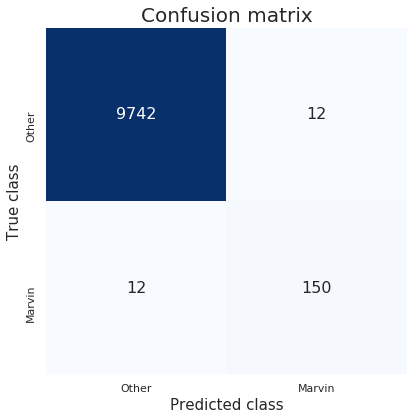

In [72]:
showResultsOC(test_pred, test_true)